# Cats Vs Dogs

This is the third notebook of my final project of the second semester as a data science student

In this notebook I will try to get the highest accuracy on the Cats vs Dogs data set.

[conclusion](#conclusion)

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob
import random
%matplotlib inline
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')

First lets load al the paths of the images

In [3]:
path = "D:\\ML_SEM2\\train"
train_path = []
for file in os.listdir(path):
    train_path.append(path + "\\"+file)

Now that we have all of our paths to the picturs, lets get the arrays of theirs picturs and resize them, and categorize tham as well

In [4]:
pixels = np.ndarray((len(train_path)*2,10000)) #10000 = 100*100
categories = np.zeros(len(train_path)*2)
i =0
for path in train_path:
    image = cv2.imread(path,0)#0 means we read the images as gray scale (like Fashion-Mnist)
    image = cv2.resize(image,(100,100))# to fit to size 10000
    data = image.flatten()
    pixels[i] = data 
    if "cat" in path:
        categories[i] = 0 #cats will be classified as 0
        i = i +1
    else:
        categories[i] = 1 #dogs will be classified as 1
        i = i +1
for path in train_path: # we will flip the images to add more images to the training set 
    image = cv2.imread(path,0)
    image = cv2.flip(image,1)
    image = cv2.resize(image,(100,100))
    data = image.flatten()
    pixels[i] = data 
    if "cat" in path:
        categories[i] = 0 
        i = i +1
    else:
        categories[i] = 1 
        i = i +1

lets see that we have a balanced amount of cats and dogs

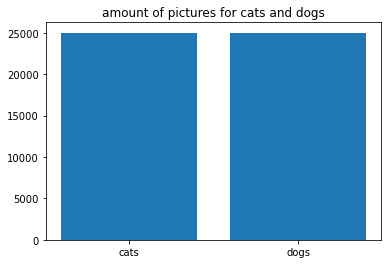

In [5]:
count = 0
for kind in categories:
    if kind ==1:
        count = count+1
amount = [count, len(categories)-count]        
xlabels = ["cats","dogs"]
plt.bar(x=xlabels, height =  amount)
plt.title("amount of pictures for cats and dogs");


as we can see we have the same amount of dog picutres and cat pictures

now lets see how an image looks from the path and how we loaded it up

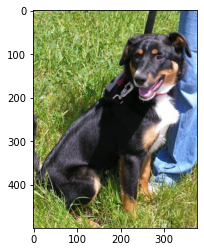

In [6]:
index = random.randint(0,24999)
image = cv2.imread(train_path[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

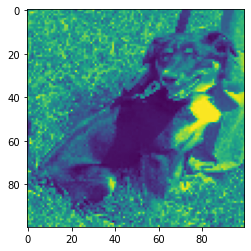

In [7]:
plt.figure()
plt.imshow(pixels[index].reshape(100,100))
plt.show()

Lets see if adding the flipped images worked

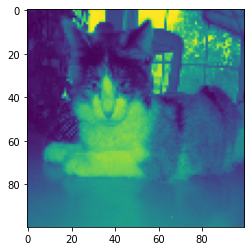

In [8]:
plt.figure()
plt.imshow(pixels[30000].reshape(100,100))
plt.show()

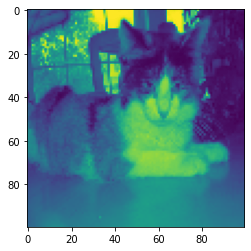

In [9]:
plt.figure()
plt.imshow(pixels[5000].reshape(100,100))
plt.show()

now we can create dataframes of our data, and move on to spliting pur data and using it to train our models

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
data = pd.DataFrame(pixels)
labels = pd.DataFrame(categories)
data_train, data_test, target_train, target_test = train_test_split(data, labels,test_size = 0.1, random_state=10)

lets use PCA to see how many pixels we can remove

In [11]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

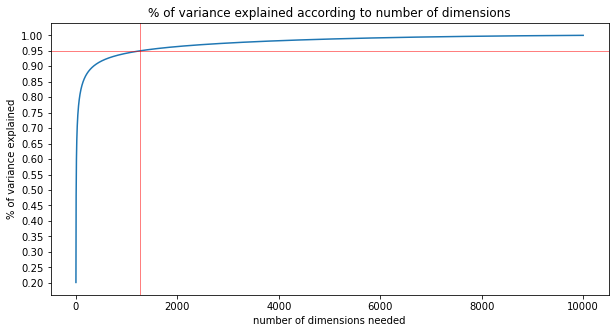

In [12]:
plt.figure(figsize = [10,5])
plt.plot(cumsum)
plt.ylabel("% of variance explained")
plt.xlabel("number of dimensions needed")
xticks = np.arange(0.2,1.01,0.05)
plt.yticks(xticks)
plt.axhline(y=0.95, linewidth=0.5, color='r');
plt.axvline(x=1265, linewidth=0.5, color='r');
plt.title("% of variance explained according to number of dimensions");

As we can see, even though we have 10000 dimensions, we only need around a 1000 to explain 95% of the variance

In [13]:
pca = PCA(n_components = 0.95)
data_reduced = pca.fit_transform(data_train)
test_reduced = pca.transform(data_test)

In [14]:
data_reduced.shape

(45000, 1265)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB      
from sklearn.linear_model import LogisticRegression

In [53]:
recover_data = pca.inverse_transform(data_reduced)
recover_test = pca.inverse_transform(test_reduced)

In [ ]:
n_range = np.arange(1000,22001,1000)
scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(data_reduced,target_train)
    pred = knn.predict(test_reduced)
    scores.append(metrics.accuracy_score(target_test,pred))

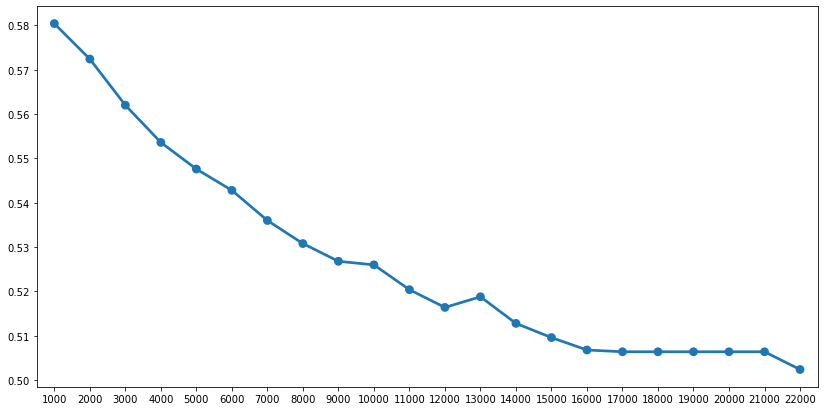

In [129]:
plt.figure(figsize = [14,7])
sns.pointplot(x = n_range, y = scores);

as we can see we dont get a good accuracy with knn lets try Random forest with grid search

In [22]:
RFC = RandomForestClassifier()
param_grid = [{"n_estimators":[100,150,200],"max_depth":[1,2,3] }]
grid_search = GridSearchCV(RFC,param_grid,cv = 5,scoring = "accuracy",return_train_score = True)
grid_search.fit(data_reduced,target_train);

In [24]:
pred = grid_search.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))
grid_search.best_estimator_

0.6088


RandomForestClassifier(max_depth=3, n_estimators=200)

# Voting

Lets try creating some more weak learners and ensembling them to a voting classifier

In [25]:
from sklearn.naive_bayes import GaussianNB      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
knn = KNeighborsClassifier(n_neighbors = 1000)
RFC = RandomForestClassifier(max_depth=3, n_estimators=200)
gnb_clf = GaussianNB()
LoR_clf = LogisticRegression(random_state=3)

In [26]:
from sklearn.ensemble import VotingClassifier
Svoting_clf = VotingClassifier(estimators = [('knn',knn),('lr',LoR_clf),('gaussian_bayes',gnb_clf),('random_forsts',RFC)],n_jobs = -1,voting='soft')
Hvoting_clf = VotingClassifier(estimators = [('knn',knn),('lr',LoR_clf),('gaussian_bayes',gnb_clf),('random_forsts',RFC)],n_jobs = -1,voting ='hard') 

In [29]:
from sklearn.metrics import accuracy_score
for clf in (knn,gnb_clf,LoR_clf,RF_clf,Svoting_clf,Hvoting_clf):
    clf.fit(data_reduced,target_train)
    pred = clf.predict(test_reduced)
    print(clf.__class__.__name__, accuracy_score(target_test,pred))

KNeighborsClassifier 0.606
GaussianNB 0.5612
LogisticRegression 0.5528
RandomForestClassifier 0.606
VotingClassifier 0.5624
VotingClassifier 0.5996


# Boosting

As we see tha voting classifier wanst much of a sucsess, lets try Boosting next, well grid search across a couple parameters ti see which one gives the best result

In [ ]:
xgb = xgboost.XGBClassifier()
param_grid = [{"n_estimators":[100,150,200],"learning_rate":[0.25,0.5,1.0] }]
grid_search = GridSearchCV(xgb,param_grid,cv = 5,scoring = "accuracy",return_train_score = True)
grid_search.fit(data_reduced,target_train)

In [25]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
pred = grid_search.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))

0.6136


In [36]:
xgb = xgboost.XGBClassifier(n_estimators=200,learning_rate=0.25)
xgb.fit(data_reduced,target_train)
pred = xgb.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))

[23:56:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6802


In [22]:
ada = AdaBoostClassifier()
param_grid = [{"n_estimators":[100,150,200],"learning_rate":[0.25,0.5,1.0]}]
grid_search = GridSearchCV(ada,param_grid,cv = 5,scoring = "accuracy",return_train_score = True)
grid_search.fit(data_reduced,target_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid=[{'learning_rate': [0.25, 0.5, 1.0],
                          'n_estimators': [100, 150, 200]}],
             return_train_score=True, scoring='accuracy')

In [23]:
grid_search.best_estimator_

AdaBoostClassifier(learning_rate=0.5, n_estimators=200)

In [24]:
pred = grid_search.predict(test_reduced)
print(metrics.accuracy_score(target_test,pred))

0.6398


As we can see, xgboost with 200 trees and a learning rate of 0.25 gives us 68% accuracy

lets check some of his predictions 

first lets draw 15 random numbers,  than assign title according to the predictions, and show the images

In [ ]:
indexes = np.array(random.sample(range(4999), 20))

In [ ]:
titles = []
for i in indexes:
    if pred[i] == 1:
        titles.append("this is a dog")
    else:
        titles.append("this is a cat")

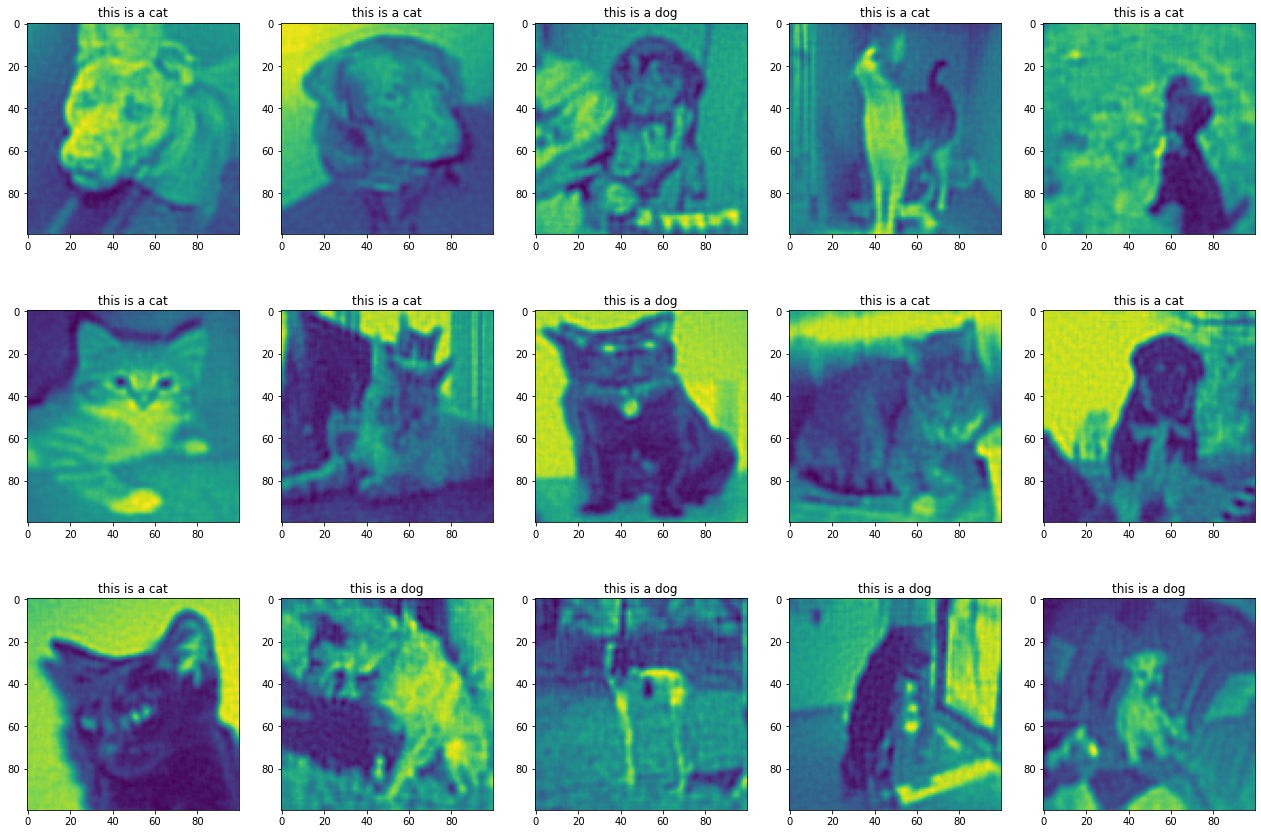

In [96]:
fig, axs = plt.subplots(3, 5, figsize=(22,15))
i = 0;
for row in range(3):
    for col in range(5):
        position = indexes[i]
        axs[row][col].title.set_text(titles[i])
        axs[row][col].imshow(recover_test[position].reshape(100,100))
        i = i+1

Lets get the test set and check our results on it

In [105]:
test_path = "D:\\ML_SEM2\\test1"
tests = []
for file in os.listdir(test_path):
    tests.append(test_path + "\\"+file)

In [126]:
pixels = np.ndarray((len(tests),10000)) #10000 = 100*100
i =0
for path in tests:
    image = cv2.imread(path,0)#0 means we read the images as gray scale (like Fashion-Mnist)
    image = cv2.resize(image,(100,100))# to fit to size 10000
    data = image.flatten()
    pixels[i] = data
    i = i+1

In [127]:
index = random.randint(0,12499)
pixels[index]

array([ 29.,  29.,  31., ..., 193., 192., 192.])

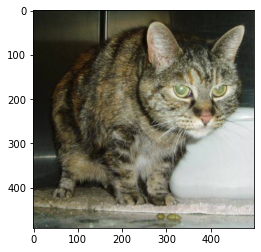

In [128]:
image = cv2.imread(tests[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

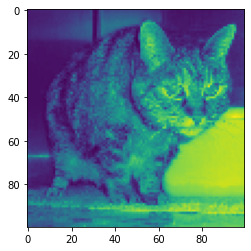

In [129]:
plt.figure()
plt.imshow(pixels[index].reshape(100,100))
plt.show()

In [130]:
test_reduced_real = pca.transform(pixels)

In [131]:
recover_test_real = pca.inverse_transform(test_reduced_real)

In [132]:
pred = xgb.predict(test_reduced_real)

In [138]:
indexes = np.array(random.sample(range(12499), 20))
titles = []
for i in indexes:
    if pred[i] == 1:
        titles.append("this is a dog")
    else:
        titles.append("this is a cat")

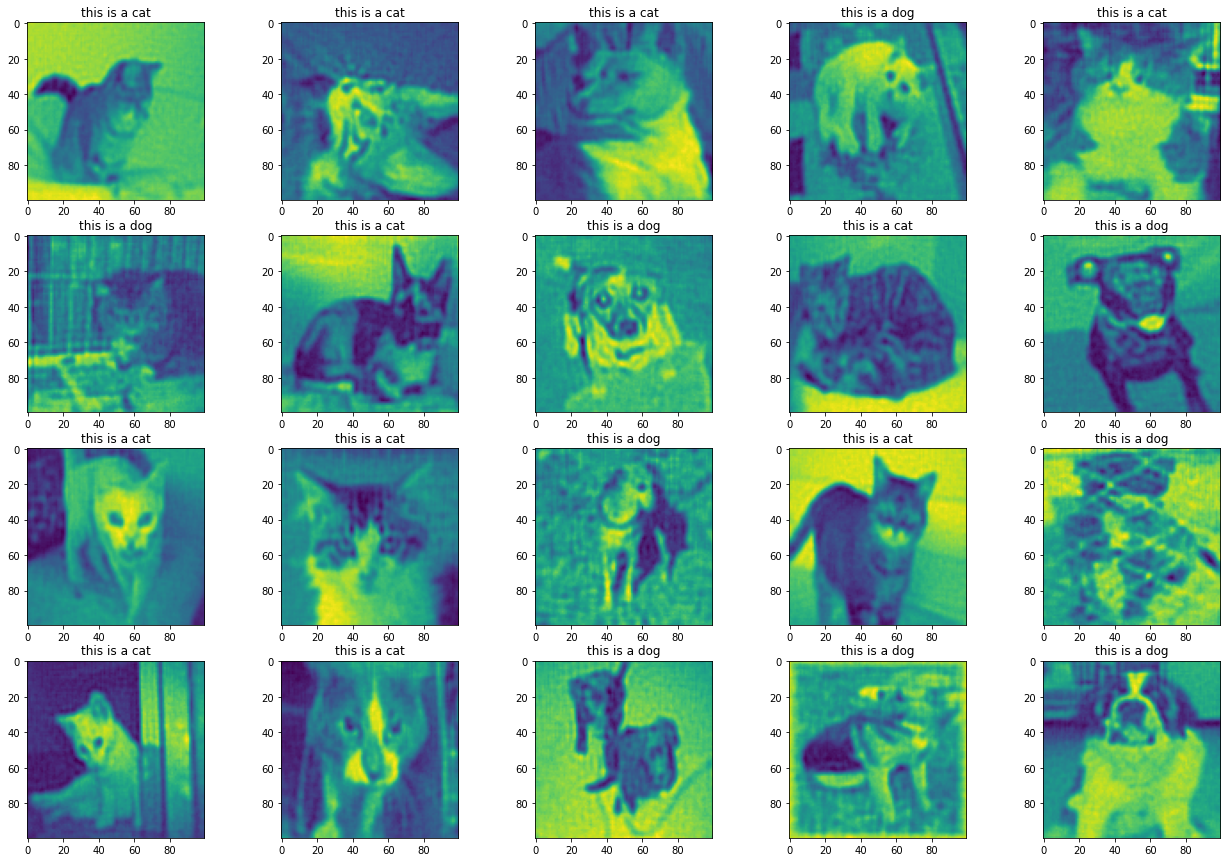

In [139]:
fig, axs = plt.subplots(4, 5, figsize=(22,15))
i = 0;
for row in range(4):
    for col in range(5):
        position = indexes[i]
        axs[row][col].title.set_text(titles[i])
        axs[row][col].imshow(recover_test_real[position].reshape(100,100))
        i = i+1

# Conclusion <a id='conclusion'></a>

At this notebook I had to first figure out how I want to read all the images and change to an array so I can train my models on it. I reshaped all the images to a constent size, and then also flipped images to add more volume to the training set.

In this notebook I used a reduced amount of models, and got the best accuracy (68%) with the XGboost classifier.

To finish the notebook I drawed 15 images from the validation set to see the image and the prediction the model gave to it, and then drawed another 20 images from the original test set to see how my model predicts those picturs.